# Image-Based Meta-Analysis

In [1]:
# First, import the necessary modules and functions
import os
from datetime import datetime

import matplotlib.pyplot as plt
from myst_nb import glue
from nilearn import plotting
from repo2data.repo2data import Repo2Data

import nimare

start = datetime.now()

# Install the data if running locally, or points to cached data if running on neurolibre
DATA_REQ_FILE = os.path.join("../binder/data_requirement.json")
FIG_DIR = os.path.abspath("../images")

# Download data
repo2data = Repo2Data(DATA_REQ_FILE)
data_path = repo2data.install()
data_path = os.path.join(data_path[0], "data")

/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


---- repo2data starting ----
/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/repo2data
Config from file :
../binder/data_requirement.json
Destination:
./../data/nimare-paper

Info : ./../data/nimare-paper already downloaded


Image-based meta-analysis (IBMA) methods perform a meta-analysis directly on brain images (either whole-brain or partial) rather than on extracted peaks.
On paper, IBMA is superior to CBMA in virtually all respects, as the availability of analysis-level parameter and variance estimates at all analyzed voxels allows researchers to use the full complement of standard meta-analysis techniques, instead of having to resort to kernel-based or other methods that require additional spatial assumptions.
In principle, given a set of maps that contains no missing values (i.e., where there are _k_ valid pairs of parameter and variance estimates at each voxel), one can simply conduct a voxel-wise version of any standard meta-analysis or meta-regression method commonly used in other biomedical or social science fields.

In practice, the utility of IBMA methods has historically been quite limited, as unthresholded statistical maps have been unavailable for the vast majority of neuroimaging studies.
However, the introduction and rapid adoption of NeuroVault {cite:p}`Gorgolewski2015-sd`, a database for unthresholded statistical images, has made image-based meta-analysis increasingly viable.
Although coverage of the literature remains limited, and IBMAs of maps drawn from the NeuroVault database are likely to omit at least some (and in some cases most) relevant studies due to limited metadata,  we believe the time is ripe for researchers to start including both CBMAs and IBMAs in published meta-analyses, with the aspirational goal of eventually transitioning exclusively to the latter.
To this end, NiMARE supports a range of different IBMA methods, including a number of estimators of the gold standard mixed-effects meta-regression model, as well as several alternative estimators suitable for use when some of the traditional inputs are unavailable.

```{note}
NiMARE's IBMA `Estimator`s are light wrappers around classes from [PyMARE](https://pymare.readthedocs.io), a library for standard (i.e., non-neuroimaging) meta-analyses developed by the same team as NiMARE.
```

In the optimal situation, meta-analysts have access to both contrast (i.e., parameter estimate) maps and their associated standard error maps for a number of studies.
With these data, researchers can fit the traditional random-effects meta-regression model using one of several methods that vary in the way they estimate the between-study variance ($\tau^{2}$).
Currently supported estimators include the **DerSimonian-Laird** method {cite:p}`DerSimonian1986-hu`, the **Hedges** method {cite:p}`Hedges1985-ka`, and **maximum-likelihood** (ML) and **restricted maximum-likelihood** (REML) approaches.
NiMARE can also perform fixed-effects meta-regression via weighted least-squares, though there are few IBMA scenarios where a fixed-effects analysis would be indicated.
It is worth noting that the non-likelihood-based estimators (i.e., DerSimonian-Laird and Hedges) have a closed-form solution, and are implemented in an extremely efficient way in NiMARE (i.e., computation is performed on all voxels in parallel).
However, these estimators also produce more biased estimates under typical conditions (e.g., when sample sizes are very small), implying a tradeoff from the user's perspective.

Alternatively, when users only have access to contrast maps and associated sample sizes, they can use the supported **Sample Size-Based Likelihood** estimator, which assumes that within-study variance is constant across studies, and uses maximum-likelihood or restricted maximum-likelihood to estimate between-study variance, as described in {cite:t}`Sangnawakij2019-mq`.
When users have access only to contrast maps, they can use the **Permuted OLS** estimator, which uses ordinary least squares and employs a max-type permutation scheme for family-wise error correction {cite:p}`Freedman1983-ld,Anderson2001-uc` that has been validated on neuroimaging data {cite:p}`Winkler2014-wh` and relies on the nilearn library.

Finally, when users only have access to z-score maps, they can use either the **Fisher's** {cite:p}`Fisher1925-zh` or the **Stouffer's** {cite:p}`Riley1949-uz` estimators.
When sample size information is available, users may incorporate that information into the Stouffer's method, via the method described in {cite:t}`Zaykin2011-fs`.

Given the paucity of image-based meta-analytic datasets, we have included the tools to build a Dataset from a NeuroVault collection of 21 pain studies, originally described in {cite:t}`Maumet2016-rr`.

In [2]:
from nimare import dataset, extract
from nimare.tests.utils import get_test_data_path

dset_dir = extract.download_nidm_pain(data_dir=data_path, overwrite=False)
dset_file = os.path.join(get_test_data_path(), "nidm_pain_dset.json")
img_dset = dataset.Dataset(dset_file)

# Point the Dataset toward the images we've downloaded
img_dset.update_path(dset_dir)

INFO:nimare.extract.utils:Dataset found in ./../data/nimare-paper/data/nidm_21pain



INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/nimare-paper/data/nidm_21pain/'


## Transforming images

Researchers may share their statistical maps in many forms, some of which are direct transformations of one another.
For example, researchers may share test statistic maps with z-statistics or t-statistics, and, as long as we know the degrees of freedom associated with the t-test, we can convert between the two easily. To that end, NiMARE includes a class, {py:class}`nimare.transforms.ImageTransformer`, which will calculate target image types from available ones, as long as the available images are compatible with said transformation.

Here, we use `ImageTransformer` to calculate z-statistic and variance maps for all studies with compatible images.
This allows us to apply more image-based meta-analysis algorithms to the `Dataset`.

In [3]:
from nimare import transforms

img_transformer = transforms.ImageTransformer(target=["z", "varcope"], overwrite=False)
img_dset = img_transformer.transform(img_dset)

INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/nimare-paper/data/nidm_21pain/'


In [4]:
# Here we delete the recent variables for the sake of reducing memory usage
del img_transformer

Now that we have filled in as many gaps in the `Dataset` as possible, we can start running meta-analyses.
We will start with a DerSimonian-Laird meta-analysis ({py:class}`nimare.meta.ibma.DerSimonianLaird`).

In [5]:
from nimare import meta

dsl_meta = meta.ibma.DerSimonianLaird()
dsl_results = dsl_meta.fit(img_dset)

# Retain the z-statistic map for later use
dsl_img = dsl_results.get_map("z", return_type="image")

In [6]:
# Here we delete the recent variables for the sake of reducing memory usage
del dsl_meta, dsl_results

Now we will apply other available IBMA `Estimator`s to the same `Dataset`, and save their results to files for comparison.

In [7]:
# Stouffer's
stouffers_meta = meta.ibma.Stouffers(use_sample_size=False)
stouffers_results = stouffers_meta.fit(img_dset)
stouffers_img = stouffers_results.get_map("z", return_type="image")
del stouffers_meta, stouffers_results

# Stouffer's with weighting based on sample size
wstouffers_meta = meta.ibma.Stouffers(use_sample_size=True)
wstouffers_results = wstouffers_meta.fit(img_dset)
wstouffers_img = wstouffers_results.get_map("z", return_type="image")
del wstouffers_meta, wstouffers_results

# Fisher's
fishers_meta = meta.ibma.Fishers()
fishers_results = fishers_meta.fit(img_dset)
fishers_img = fishers_results.get_map("z", return_type="image")
del fishers_meta, fishers_results

# Permuted Ordinary Least Squares
ols_meta = meta.ibma.PermutedOLS()
ols_results = ols_meta.fit(img_dset)
ols_img = ols_results.get_map("z", return_type="image")
del ols_meta, ols_results

# Weighted Least Squares
wls_meta = meta.ibma.WeightedLeastSquares()
wls_results = wls_meta.fit(img_dset)
wls_img = wls_results.get_map("z", return_type="image")
del wls_meta, wls_results

# Hedges'
hedges_meta = meta.ibma.Hedges()
hedges_results = hedges_meta.fit(img_dset)
hedges_img = hedges_results.get_map("z", return_type="image")
del hedges_meta, hedges_results

# Use atlas for likelihood-based estimators
from nilearn import datasets, image, input_data

atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")

# nilearn's NiftiLabelsMasker cannot handle NaNs at the moment,
# and some of the NIDM-Results packs' beta images have NaNs at the edge of the
# brain.
# So, we will create a reduced version of the atlas for this analysis.
nan_mask = image.math_img("~np.any(np.isnan(img), axis=3)", img=img_dset.images["beta"].tolist())
nanmasked_atlas = image.math_img("mask * atlas", mask=nan_mask, atlas=atlas["maps"])
masker = input_data.NiftiLabelsMasker(nanmasked_atlas)
del atlas, nan_mask, nanmasked_atlas

# Variance-Based Likelihood
vbl_meta = meta.ibma.VarianceBasedLikelihood(method="reml", mask=masker)
vbl_results = vbl_meta.fit(img_dset)
vbl_img = vbl_results.get_map("z", return_type="image")
del vbl_meta, vbl_results

# Sample Size-Based Likelihood
ssbl_meta = nimare.meta.ibma.SampleSizeBasedLikelihood(method="reml", mask=masker)
ssbl_results = ssbl_meta.fit(img_dset)
ssbl_img = ssbl_results.get_map("z", return_type="image")
del ssbl_meta, ssbl_results, masker

/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/pymare/estimators/estimators.py:28: UserWarning: Input contains 48 parallel datasets (in 2nd dim of y and v). The selected estimator will loop over datasets naively, and this may be slow for large numbers of datasets. Consider using the DL, HE, or WLS estimators, which handle parallel datasets more efficiently.
  .format(n_iter))


## Comparing algorithms

Here we load the z-statistic map from each of the IBMA Estimators we've used throughout this chapter and plot them all side by side.

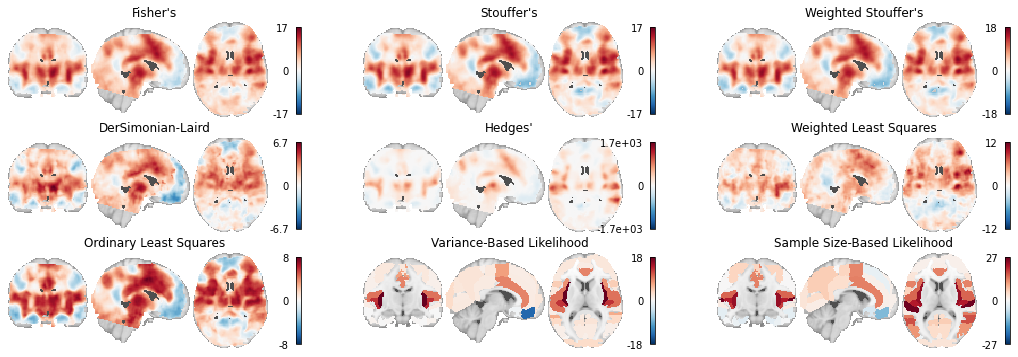

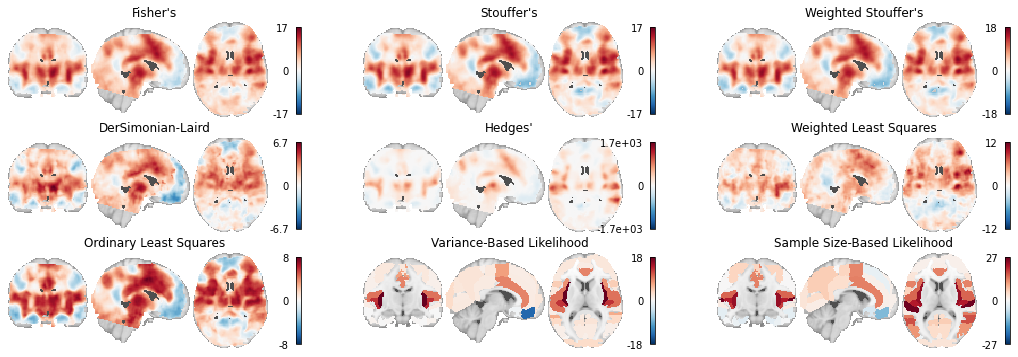

In [8]:
meta_results = {
    "DerSimonian-Laird": dsl_img,
    "Stouffer's": stouffers_img,
    "Weighted Stouffer's": wstouffers_img,
    "Fisher's": fishers_img,
    "Ordinary Least Squares": ols_img,
    "Weighted Least Squares": wls_img,
    "Hedges'": hedges_img,
    "Variance-Based Likelihood": vbl_img,
    "Sample Size-Based Likelihood": ssbl_img,
}
order = [
    ["Fisher's", "Stouffer's", "Weighted Stouffer's"],
    ["DerSimonian-Laird", "Hedges'", "Weighted Least Squares"],
    ["Ordinary Least Squares", "Variance-Based Likelihood", "Sample Size-Based Likelihood"],
]

fig, axes = plt.subplots(figsize=(18, 6), nrows=3, ncols=3)

for i_row, row_names in enumerate(order):
    for j_col, name in enumerate(row_names):
        file_ = meta_results[name]
        display = plotting.plot_stat_map(
            file_,
            annotate=False,
            axes=axes[i_row, j_col],
            cmap="RdBu_r",
            cut_coords=[5, -15, 10],
            draw_cross=False,
            figure=fig,
        )
        axes[i_row, j_col].set_title(name)

        colorbar = display._cbar
        colorbar_ticks = colorbar.get_ticks()
        if colorbar_ticks[0] < 0:
            new_ticks = [colorbar_ticks[0], 0, colorbar_ticks[-1]]
        else:
            new_ticks = [colorbar_ticks[0], colorbar_ticks[-1]]
        colorbar.set_ticks(new_ticks, update_ticks=True)

glue("figure_uncorr_ibma", fig, display=False)

```{glue:figure} figure_uncorr_ibma
:name: figure_uncorr_ibma
:align: center

An array of plots of the statistical maps produced by the image-based meta-analysis methods.
The likelihood-based meta-analyses are run on atlases instead of voxelwise.
```

In [9]:
end = datetime.now()
print(f"ibma.md took {end - start} to build.")

ibma.md took 0:01:04.950397 to build.
